In [2]:
from osgeo import gdal, ogr, osr
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glob
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
import math


In [3]:
def read_band_image(band, path):
    """
    This function takes as input the Sentinel-2 band name and the path of the 
    folder that the images are stored, reads the image and returns the data as
    an array
    input:   band           string            Sentinel-2 band name
             path           string            path of the folder
    output:  data           array (n x m)     array of the band image
             spatialRef     string            projection 
             geoTransform   tuple             affine transformation coefficients
             targetprj                        spatial reference
    """
    a = path+'*B'+band+'*.jp2'
    img = gdal.Open(glob.glob(a)[0])
    data = np.array(img.GetRasterBand(1).ReadAsArray())
    spatialRef = img.GetProjection()
    geoTransform = img.GetGeoTransform()
    targetprj = osr.SpatialReference(wkt = img.GetProjection())
    return data, spatialRef, geoTransform, targetprj

def nbr(band1, band2):
    """
    This function takes an input the arrays of the bands from the read_band_image
    function and returns the Normalized Burn ratio (NBR)
    input:  band1   array (n x m)      array of first band image e.g B8A
            band2   array (n x m)      array of second band image e.g. B12
    output: nbr     array (n x m)      normalized burn ratio
    """
    nbr = (band1 - band2) / (band1 + band2)
    return nbr

def dnbr(nbr1,nbr2):
    """
    This function takes as input the pre- and post-fire NBR and returns the dNBR
    input:  nbr1     array (n x m)       pre-fire NBR
            nbr2     array (n x m)       post-fire NBR
    output: dnbr     array (n x m)       dNBR
    """
    dnbr = nbr1 - nbr2
    return dnbr

def reproject_shp_gdal(infile, outfile, targetprj):
    """
    This function takes as input the input and output file names and the projection
    in which the input file will be reprojected and reprojects the input file using
    gdal
    input:  infile     string      input filename
            outfile    string      output filename
            targetprj              projection (output of function read_band_image)
    """
    ## reprojection with gdal 
    
    driver = ogr.GetDriverByName("ESRI Shapefile") 
    dataSource = driver.Open(infile, 1) # 0 means read-only. 1 means writeable.
    layer = dataSource.GetLayer()
    sourceprj = layer.GetSpatialRef()
    transform = osr.CoordinateTransformation(sourceprj, targetprj)
    
    # Create the output shapefile
    outDriver = ogr.GetDriverByName("Esri Shapefile")
    outDataSource = outDriver.CreateDataSource(outfile)
    outlayer = outDataSource.CreateLayer('', targetprj, ogr.wkbPolygon)
    outlayer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
    
    #Iterate over Features
    i = 0
    for feature in layer:
        transformed = feature.GetGeometryRef()
        transformed.Transform(transform) #reproject geometry

        geom = ogr.CreateGeometryFromWkb(transformed.ExportToWkb()) # create geometry from wkb (write geometry of reprojected geometry)
        defn = outlayer.GetLayerDefn() #layer definition
        feat = ogr.Feature(defn)  #create new feature
        feat.SetField('id', i) #set id
        feat.SetGeometry(geom) #set geometry
        outlayer.CreateFeature(feat) 
        i += 1
        feat = None
        
def array2raster(array, geoTransform, projection, filename):
    """ 
    This function tarnsforms a numpy array to a geotiff projected raster
    input:  array                       array (n x m)   input array
            geoTransform                tuple           affine transformation coefficients
            projection                  string          projection
            filename                    string          output filename
    output: dataset                                     gdal raster dataset
            dataset.GetRasterBand(1)                    band object of dataset
    
    """
    pixels_x = array.shape[1]
    pixels_y = array.shape[0]
    
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(
        filename,
        pixels_x,
        pixels_y,
        1,
        gdal.GDT_Float64, )
    dataset.SetGeoTransform(geoTransform)
    dataset.SetProjection(projection)
    dataset.GetRasterBand(1).WriteArray(array)
    dataset.FlushCache()  # Write to disk.
    return dataset, dataset.GetRasterBand(1)  #If you need to return, remenber to return  also the dataset because the band don`t live without dataset.
 
def clip_raster(filename, shp):
    """
    This function clips a raster based on a shapefile
    input:  filename          string                input raster filename
            shp               dataframe             input shapefile open with geopandas
    output: clipped           array (1 x n x m)     clipped array 
            clipped_meta      dict                  metadata
            cr_ext            tuple                 extent of clipped data
            gt                tuple                 affine transformation coefficients
    """
    inraster = rasterio.open(filename)
    
    extent_geojson = mapping(shp['geometry'][0])
    clipped, crop_affine = mask(inraster, 
                                shapes=[extent_geojson], 
                                nodata = np.nan,
                                crop=True)
    clipped_meta = inraster.meta.copy()
    # Update the metadata to have the new shape (x and y and affine information)
    clipped_meta.update({"driver": "GTiff",
                 "height": clipped.shape[0],
                 "width": clipped.shape[1],
                 "transform": crop_affine})
    cr_ext = rasterio.transform.array_bounds(clipped_meta['height'], 
                                            clipped_meta['width'], 
                                            clipped_meta['transform'])
    
    # transform to gdal
    gt = crop_affine.to_gdal()
    
    return clipped, clipped_meta, cr_ext, gt
    
def reclassify(array):
    """
    This function reclassifies an array
    input:  array           array (n x m)    input array
    output: reclass         array (n x m)    reclassified array
    """
    reclass = np.zeros((array.shape[0],array.shape[1]))
    for i in range(0,array.shape[0]):
        for j in range(0,array.shape[1]):
            if math.isnan(array[i,j]):
                reclass[i,j] = np.nan
            elif array[i,j] < 0.1:
                reclass[i,j] = 1
            elif array[i,j] < 0.27:
                 reclass[i,j] = 2
            elif array[i,j] < 0.44:
                 reclass[i,j] = 3
            elif array[i,j] < 0.66:
                 reclass[i,j] = 4
            else:
                reclass[i,j] = 5
                
    return reclass

In [4]:
# Paths "C:\Users\sures\Downloads\pre"
path_prefire = r"C:/Users/sures/Downloads/pre/S2B_MSIL2A_20241218T183709_N0511_R027_T11SLT_20241218T222347.SAFE/S2B_MSIL2A_20241218T183709_N0511_R027_T11SLT_20241218T222347.SAFE/GRANULE/L2A_T11SLT_A040665_20241218T183708/IMG_DATA/R20m/"
path_postfire = r"C:/Users/sures/Downloads/post/S2A_MSIL2A_20250112T183731_N0511_R027_T11SLT_20250112T222951.SAFE/S2A_MSIL2A_20250112T183731_N0511_R027_T11SLT_20250112T222951.SAFE/GRANULE/L2A_T11SLT_A049931_20250112T183727/IMG_DATA/R20m/"

# Define shapefile
infile_shp = r"C:\Users\sures\los\shapefile\new_shapefile.shp"

# Define reprojected shapefile
outfile_shp = r"C:\Users\sures\los\projected\projected_new##.shp"

# Name of the output dNBR raster file
filename = r"C:\Users\sures\los\projected\dNBR_new##.tiff"

# Name of clipped dNBR raster
filename2 = r"C:\Users\sures\los\projected\dNBR_clipped_new##.tiff"

# Path to save figure
fname = r"C:\Users\sures\los\projected\map_new##.png"

In [5]:
# Sentinel-2 Bands used for NBR calculation 
band1 = '8A'
band2 = '12'
    
# Read the pre-fire band images 
(pre_fire_b8A, crs, geoTransform, targetprj) = read_band_image(band1, path_prefire)
(pre_fire_b12, crs, geoTransform, targetprj) = read_band_image(band2, path_prefire)
    
# Calculation of pre-fire NBR
pre_fire_nbr = nbr(pre_fire_b8A.astype(int),pre_fire_b12.astype(int))

# Read the post-fire band images
(post_fire_b8A, crs, geoTransform, targetprj) = read_band_image(band1, path_postfire)
(post_fire_b12, crs, geoTransform, targetprj) = read_band_image(band2, path_postfire)
    
# Calculation of post-fire NBR
post_fire_nbr = nbr(post_fire_b8A.astype(int),post_fire_b12.astype(int))
    
# Calculation of dNBR
DNBR = dnbr(pre_fire_nbr,post_fire_nbr)
    
# Reprojection of shapefile with gdal to match projection of Sentinel-2 images
reproject_shp_gdal(infile_shp, outfile_shp, targetprj)
    
# Read the reprojected shapefile
fire_boundary = gpd.read_file(outfile_shp)
    
# project dNBR to images projection
dnbr_tif, dnbr_tifBand = array2raster(DNBR, geoTransform, crs, filename)
    
# clip raster dNBR file to Empedrado shapefile
(clipped_dnbr, clipped_dnbr_meta, cr_extent, gt) = clip_raster(filename, fire_boundary)
clipped_ds , clipped_ds_rasterband = array2raster(clipped_dnbr[0], gt, crs, filename2)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


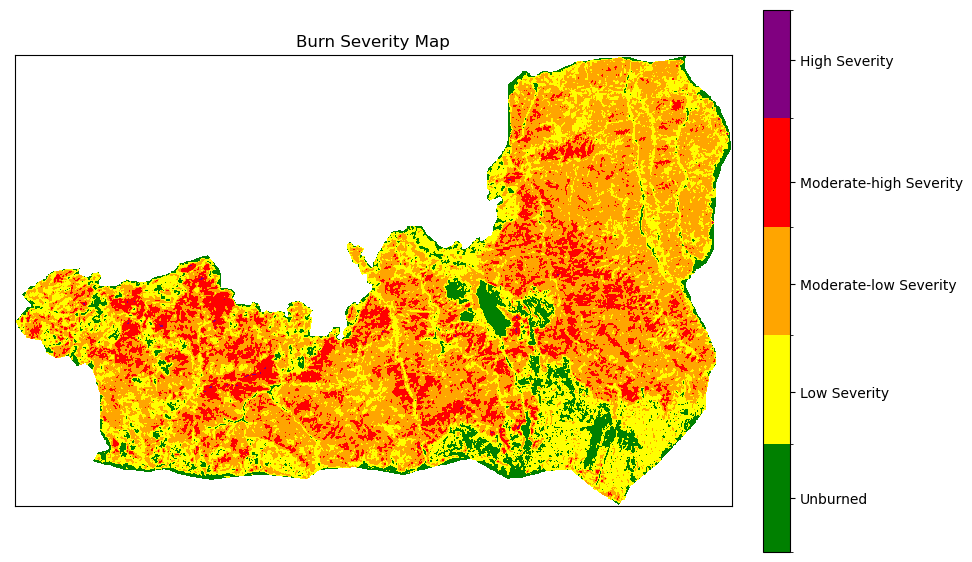

<Figure size 640x480 with 0 Axes>

In [6]:
# plot 
import matplotlib.pyplot as plt
import matplotlib.colors
#set colors for plotting and classes
cmap = matplotlib.colors.ListedColormap(['green','yellow','orange','red','purple'])
cmap.set_over('purple')
cmap.set_under('white')
bounds = [-0.5, 0.1, 0.27, 0.440, 0.660, 1.3]        
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)  

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(clipped_ds_rasterband.ReadAsArray(), cmap=cmap, norm = norm)
plt.title('Burn Severity Map')
cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04, ticks=[-0.2, 0.18, 0.35, 0.53, 1])
cbar.ax.set_yticklabels(['Unburned', 'Low Severity', 'Moderate-low Severity', 'Moderate-high Severity', 'High Severity'])
plt.show()
plt.savefig(fname, bbox_inches="tight") 

In [7]:
reclass = reclassify(clipped_ds_rasterband.ReadAsArray())

k = ['Unburned', 'Low severity', 'Moderate-low severity', 'Moderate-high severity', 'High severity']
total_area = reclass.size * 0.04  # Total area in hectares

for i in range(1, 6):
    class_area = (reclass == i).sum() * 0.04  # Area of each class in hectares
    percentage = (class_area / total_area) * 100  # Calculate percentage
    print("%s: %.2f hectares (%.2f%%)" % (k[i-1], class_area, percentage))


Unburned: 945.68 hectares (5.08%)
Low severity: 2721.56 hectares (14.62%)
Moderate-low severity: 4626.24 hectares (24.86%)
Moderate-high severity: 1559.96 hectares (8.38%)
High severity: 12.48 hectares (0.07%)


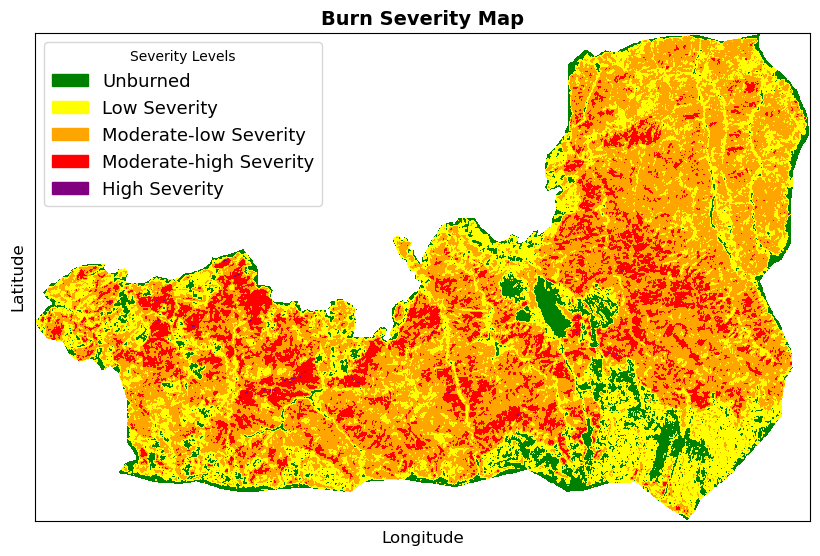

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors

# Set colors for plotting and classes
cmap = matplotlib.colors.ListedColormap(['green', 'yellow', 'orange', 'red', 'purple'])
cmap.set_over('purple')
cmap.set_under('purple')
bounds = [-0.5, 0.1, 0.27, 0.44, 0.66, 1.3]        
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)  

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(clipped_ds_rasterband.ReadAsArray(), cmap=cmap, norm=norm)

# Title and labels
plt.title('Burn Severity Map', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Colorbar
#cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04, ticks=[-0.2, 0.18, 0.35, 0.53, 1])
#cbar.ax.set_yticklabels(['Unburned', 'Low Severity', 'Moderate-low Severity', 'Moderate-high Severity', 'High Severity'])

# Add legend manually
import matplotlib.patches as mpatches
legend_labels = ['Unburned', 'Low Severity', 'Moderate-low Severity', 'Moderate-high Severity', 'High Severity']
colors = ['green', 'yellow', 'orange', 'red', 'purple']
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=patches, loc='upper left', title="Severity Levels", fontsize=13)

# Show and save the figure
plt.show()
plt.savefig(fname, bbox_inches="tight")  


In [26]:
# Calculate total area excluding no-data values
valid_pixels = reclass != -9999  # Assuming -9999 is the no-data value (adjust if needed)
total_area = valid_pixels.sum() * 0.04  # Only valid pixels contribute to the total area


In [29]:
import numpy as np

# Mask out NaN values for area calculations
valid_pixels = np.isfinite(reclass)  # This will mask out NaN values

# Calculate the total area considering only valid (non-NaN) pixels
total_area = valid_pixels.sum() * 0.04  # Total area in hectares

# Print out the area and percentage for each class
k = ['Unburned', 'Low severity', 'Moderate-low severity', 'Moderate-high severity', 'High severity']

total_class_area = 0
for i in range(1, 6):
    class_area = ((reclass == i) & valid_pixels).sum() * 0.04  # Only consider valid pixels
    total_class_area += class_area
    percentage = (class_area / total_area) * 100  # Calculate percentage
    print("%s: %.2f hectares (%.2f%%)" % (k[i-1], class_area, percentage))

# Check if the sum of individual class areas equals the total area
print("Total calculated area: %.2f hectares" % total_class_area)
print("Total area in the raster: %.2f hectares" % total_area)

# Recalculate total percentage
total_percentage = sum(((reclass == i) & valid_pixels).sum() * 0.04 / total_area * 100 for i in range(1, 6))
print("Total percentage: %.2f%%" % total_percentage)


Unburned: 945.68 hectares (9.59%)
Low severity: 2721.56 hectares (27.59%)
Moderate-low severity: 4626.24 hectares (46.89%)
Moderate-high severity: 1559.96 hectares (15.81%)
High severity: 12.48 hectares (0.13%)
Total calculated area: 9865.92 hectares
Total area in the raster: 9865.92 hectares
Total percentage: 100.00%
